In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [3]:
# Define file path and chunk size
TRAIN_FILE_PATH = r"C:\Users\spand\Projects\MICROSOFT_CYBERSECURITY\Guvi---Microsoft-Cybersecurity\Data\Raw\new_train_sample.csv"  
TEST_FILE_PATH = r"C:\Users\spand\Projects\MICROSOFT_CYBERSECURITY\Guvi---Microsoft-Cybersecurity\Data\Raw\GUIDE_Test.csv"
CHUNK_SIZE = 50000  

In [4]:
# Function to load a large dataset easily
def data_loader(file_path, chunksize=CHUNK_SIZE):
    """
    Loads a large CSV file efficiently in chunks, cleans it, and combines it into a single DataFrame.

    Args:
        file_path (str): Path to the CSV file to be loaded.
        chunksize (int): Number of rows per chunk to load into memory. Default is CHUNK_SIZE.

    Returns:
        DataFrame: A cleaned, combined DataFrame with all chunks concatenated.
    """

    chunk_list = []  # List to store processed chunks

    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
        chunk = chunk.drop(columns=['Unnamed: 0'], errors='ignore')
        chunk_list.append(chunk)  # Append each chunk to the list
    
    # Combine all chunks into a single DataFrame
    full_data = pd.concat(chunk_list, ignore_index=True)
    return full_data

In [5]:
# Load the full training dataset
train_data = data_loader(TRAIN_FILE_PATH)
pd.set_option('display.max_columns', None)
train_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,1709396985476,26,18583,687462,2024-06-06T05:56:47.000Z,31,813,Malware,NaN,BenignPositive,NaN,NaN,File,Related,98799,1296,360606,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,Casdet,4132,4227,3586,NaN,NaN,5,66,NaN,Suspicious,Malicious,242,1445,10630
1,927712939180,33,5065,3990,2024-06-03T10:45:09.000Z,38,25,Impact,NaN,BenignPositive,NaN,NaN,Machine,Impacted,98799,138268,360606,160396,441377,673934,425863,453297,3142,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1090921697002,201,150787,807590,2024-06-13T03:36:40.000Z,419,444,Execution,T1047;T1059;T1053;T1569;T1059.001;T1053.002;T1...,BenignPositive,NaN,NaN,Machine,Impacted,98799,138268,360606,160396,441377,673934,425863,453297,4181,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,Destination,5,66,NaN,NaN,NaN,242,1445,10630
3,1434519079555,204,108287,28575,2024-06-08T16:54:57.000Z,44,1233,SuspiciousActivity,NaN,TruePositive,NaN,NaN,File,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,97007,9177,3586,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,1005022347708,54,528202,1458226,2024-06-09T02:48:01.000Z,102,58829,Exfiltration,NaN,BenignPositive,NaN,NaN,File,Impacted,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,39978,114449,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [6]:
# Basic Exploration
print(f"Dataset shape: {train_data.shape}")

Dataset shape: (4758418, 45)


In [7]:
print("Columns in the dataset:")
train_data.columns

Columns in the dataset:


Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City'],
      dtype='object')

In [8]:
print("Data type of columns in the dataset:")
train_data.dtypes

Data type of columns in the dataset:


Id                      int64
OrgId                   int64
IncidentId              int64
AlertId                 int64
Timestamp              object
DetectorId              int64
AlertTitle              int64
Category               object
MitreTechniques        object
IncidentGrade          object
ActionGrouped          object
ActionGranular         object
EntityType             object
EvidenceRole           object
DeviceId                int64
Sha256                  int64
IpAddress               int64
Url                     int64
AccountSid              int64
AccountUpn              int64
AccountObjectId         int64
AccountName             int64
DeviceName              int64
NetworkMessageId        int64
EmailClusterId        float64
RegistryKey             int64
RegistryValueName       int64
RegistryValueData       int64
ApplicationId           int64
ApplicationName         int64
OAuthApplicationId      int64
ThreatFamily           object
FileName                int64
FolderPath

In [9]:
# Display distribution of target variable
print("\n--- TARGET VARIABLE DISTRIBUTION ---")
print(train_data['IncidentGrade'].value_counts(), '\n')
print(train_data['IncidentGrade'].value_counts(normalize=True) * 100)


--- TARGET VARIABLE DISTRIBUTION ---
IncidentGrade
BenignPositive    2054774
TruePositive      1662087
FalsePositive     1015782
Name: count, dtype: int64 

IncidentGrade
BenignPositive    43.417050
TruePositive      35.119636
FalsePositive     21.463313
Name: proportion, dtype: float64


In [10]:
# Check for missing values
print("\n--- MISSING VALUES DATA ---")
missing = train_data.isnull().sum()
missing_percent = (missing / len(train_data)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Missing Percentage': missing_percent})
print(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False))


--- MISSING VALUES DATA ---
                   Missing Values  Missing Percentage
ResourceType              4754863           99.925290
ActionGranular            4730205           99.407093
ActionGrouped             4730205           99.407093
ThreatFamily              4721038           99.214445
EmailClusterId            4710241           98.987542
AntispamDirection         4669846           98.138625
Roles                     4649117           97.702997
SuspicionLevel            4037145           84.842168
LastVerdict               3642221           76.542687
MitreTechniques           2733136           57.437913
IncidentGrade               25775            0.541672


In [11]:
# 2. DATA CLEANING
print("\n--- DATA CLEANING ---")

# Create a copy of the dataframe for cleaning
clean_df = train_data.copy()

# Drop columns with >50% missing values
print("Dropping columns with >50% missing values...")
clean_df = clean_df.drop(missing_percent[missing_percent > 50].index, axis=1)

# Drop rows with null values in target variable 
print("Dropping rows with null values in target variable ...")
clean_df = clean_df.dropna(subset=['IncidentGrade'])

# Convert Timestamp to datetime if it's not already
if clean_df['Timestamp'].dtype == 'object':
    print("Converting Timestamp to datetime...")
    clean_df['Timestamp'] = pd.to_datetime(clean_df['Timestamp'], errors='coerce')
    
    # Extract time-related features
    clean_df['Hour'] = clean_df['Timestamp'].dt.hour
    clean_df['Day'] = clean_df['Timestamp'].dt.day
    clean_df['DayOfWeek'] = clean_df['Timestamp'].dt.dayofweek
    clean_df['Month'] = clean_df['Timestamp'].dt.month
    clean_df['Year'] = clean_df['Timestamp'].dt.year

# Remove duplicates if any
duplicates = clean_df.duplicated().sum()
if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    clean_df = clean_df.drop_duplicates()

print(f"Shape after cleaning: {clean_df.shape}")


--- DATA CLEANING ---
Dropping columns with >50% missing values...
Dropping rows with null values in target variable ...
Converting Timestamp to datetime...
Removing 155243 duplicate rows...
Shape after cleaning: (4577400, 40)


In [12]:
clean_df.nunique()

Id                     642342
OrgId                    5236
IncidentId             421530
AlertId               1150459
Timestamp              719084
DetectorId               7369
AlertTitle              74710
Category                   20
IncidentGrade               3
EntityType                 31
EvidenceRole                2
DeviceId                55204
Sha256                  73078
IpAddress              195384
Url                     85332
AccountSid             265788
AccountUpn             394186
AccountObjectId        257733
AccountName            272375
DeviceName              80956
NetworkMessageId       260032
RegistryKey               937
RegistryValueName         401
RegistryValueData         496
ApplicationId            1003
ApplicationName          1610
OAuthApplicationId        416
FileName               142641
FolderPath              59652
ResourceIdName           1497
OSFamily                    6
OSVersion                  48
CountryCode               212
State     

In [13]:
clean_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,4577400.0,8.419716e+11,4.965472e+11,0.0,4.123169e+11,8.418136e+11,1.271310e+12,1.709397e+12
OrgId,4577400.0,1.730889e+02,3.731760e+02,0.0,9.000000e+00,4.200000e+01,1.610000e+02,6.129000e+03
IncidentId,4577400.0,6.973234e+04,1.203110e+05,0.0,4.630000e+02,9.215000e+03,8.201100e+04,5.997030e+05
AlertId,4577400.0,4.110693e+05,4.605476e+05,0.0,2.135500e+04,2.218820e+05,6.850460e+05,1.721456e+06
DetectorId,4577400.0,1.096099e+02,4.252050e+02,0.0,2.000000e+00,9.000000e+00,4.600000e+01,9.522000e+03
AlertTitle,4577400.0,2.862698e+03,1.106618e+04,0.0,2.000000e+00,1.300000e+01,1.950000e+02,1.131730e+05
DeviceId,4577400.0,9.556584e+04,1.659709e+04,0.0,9.879900e+04,9.879900e+04,9.879900e+04,9.879900e+04
Sha256,4577400.0,1.283791e+05,3.454983e+04,0.0,1.382680e+05,1.382680e+05,1.382680e+05,1.382680e+05
IpAddress,4577400.0,2.829348e+05,1.430936e+05,0.0,3.606060e+05,3.606060e+05,3.606060e+05,3.606060e+05
Url,4577400.0,1.506187e+05,3.711049e+04,0.0,1.603960e+05,1.603960e+05,1.603960e+05,1.603960e+05


In [14]:
num_features = [feature for feature in clean_df.columns if clean_df[feature].dtype != 'O']
num_features

['Id',
 'OrgId',
 'IncidentId',
 'AlertId',
 'Timestamp',
 'DetectorId',
 'AlertTitle',
 'DeviceId',
 'Sha256',
 'IpAddress',
 'Url',
 'AccountSid',
 'AccountUpn',
 'AccountObjectId',
 'AccountName',
 'DeviceName',
 'NetworkMessageId',
 'RegistryKey',
 'RegistryValueName',
 'RegistryValueData',
 'ApplicationId',
 'ApplicationName',
 'OAuthApplicationId',
 'FileName',
 'FolderPath',
 'ResourceIdName',
 'OSFamily',
 'OSVersion',
 'CountryCode',
 'State',
 'City',
 'Hour',
 'Day',
 'DayOfWeek',
 'Month',
 'Year']

In [15]:
cat_features = [feature for feature in clean_df.columns if clean_df[feature].dtype == 'O']
cat_features

['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']


--- TARGET VARIABLE ANALYSIS ---

Incident Grade Distribution:
IncidentGrade
BenignPositive    1973943
TruePositive      1608957
FalsePositive      994500
Name: count, dtype: int64


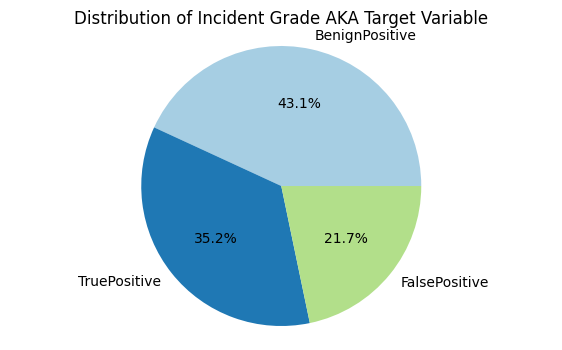

In [16]:
# TARGET VARIABLE ANALYSIS
print("\n--- TARGET VARIABLE ANALYSIS ---")
print("\nIncident Grade Distribution:")
grade_counts = clean_df['IncidentGrade'].value_counts()
print(grade_counts)

plt.figure(figsize=(7, 4))
plt.pie(grade_counts, labels=grade_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Distribution of Incident Grade AKA Target Variable', fontsize=12)
plt.axis('equal') 
plt.show()

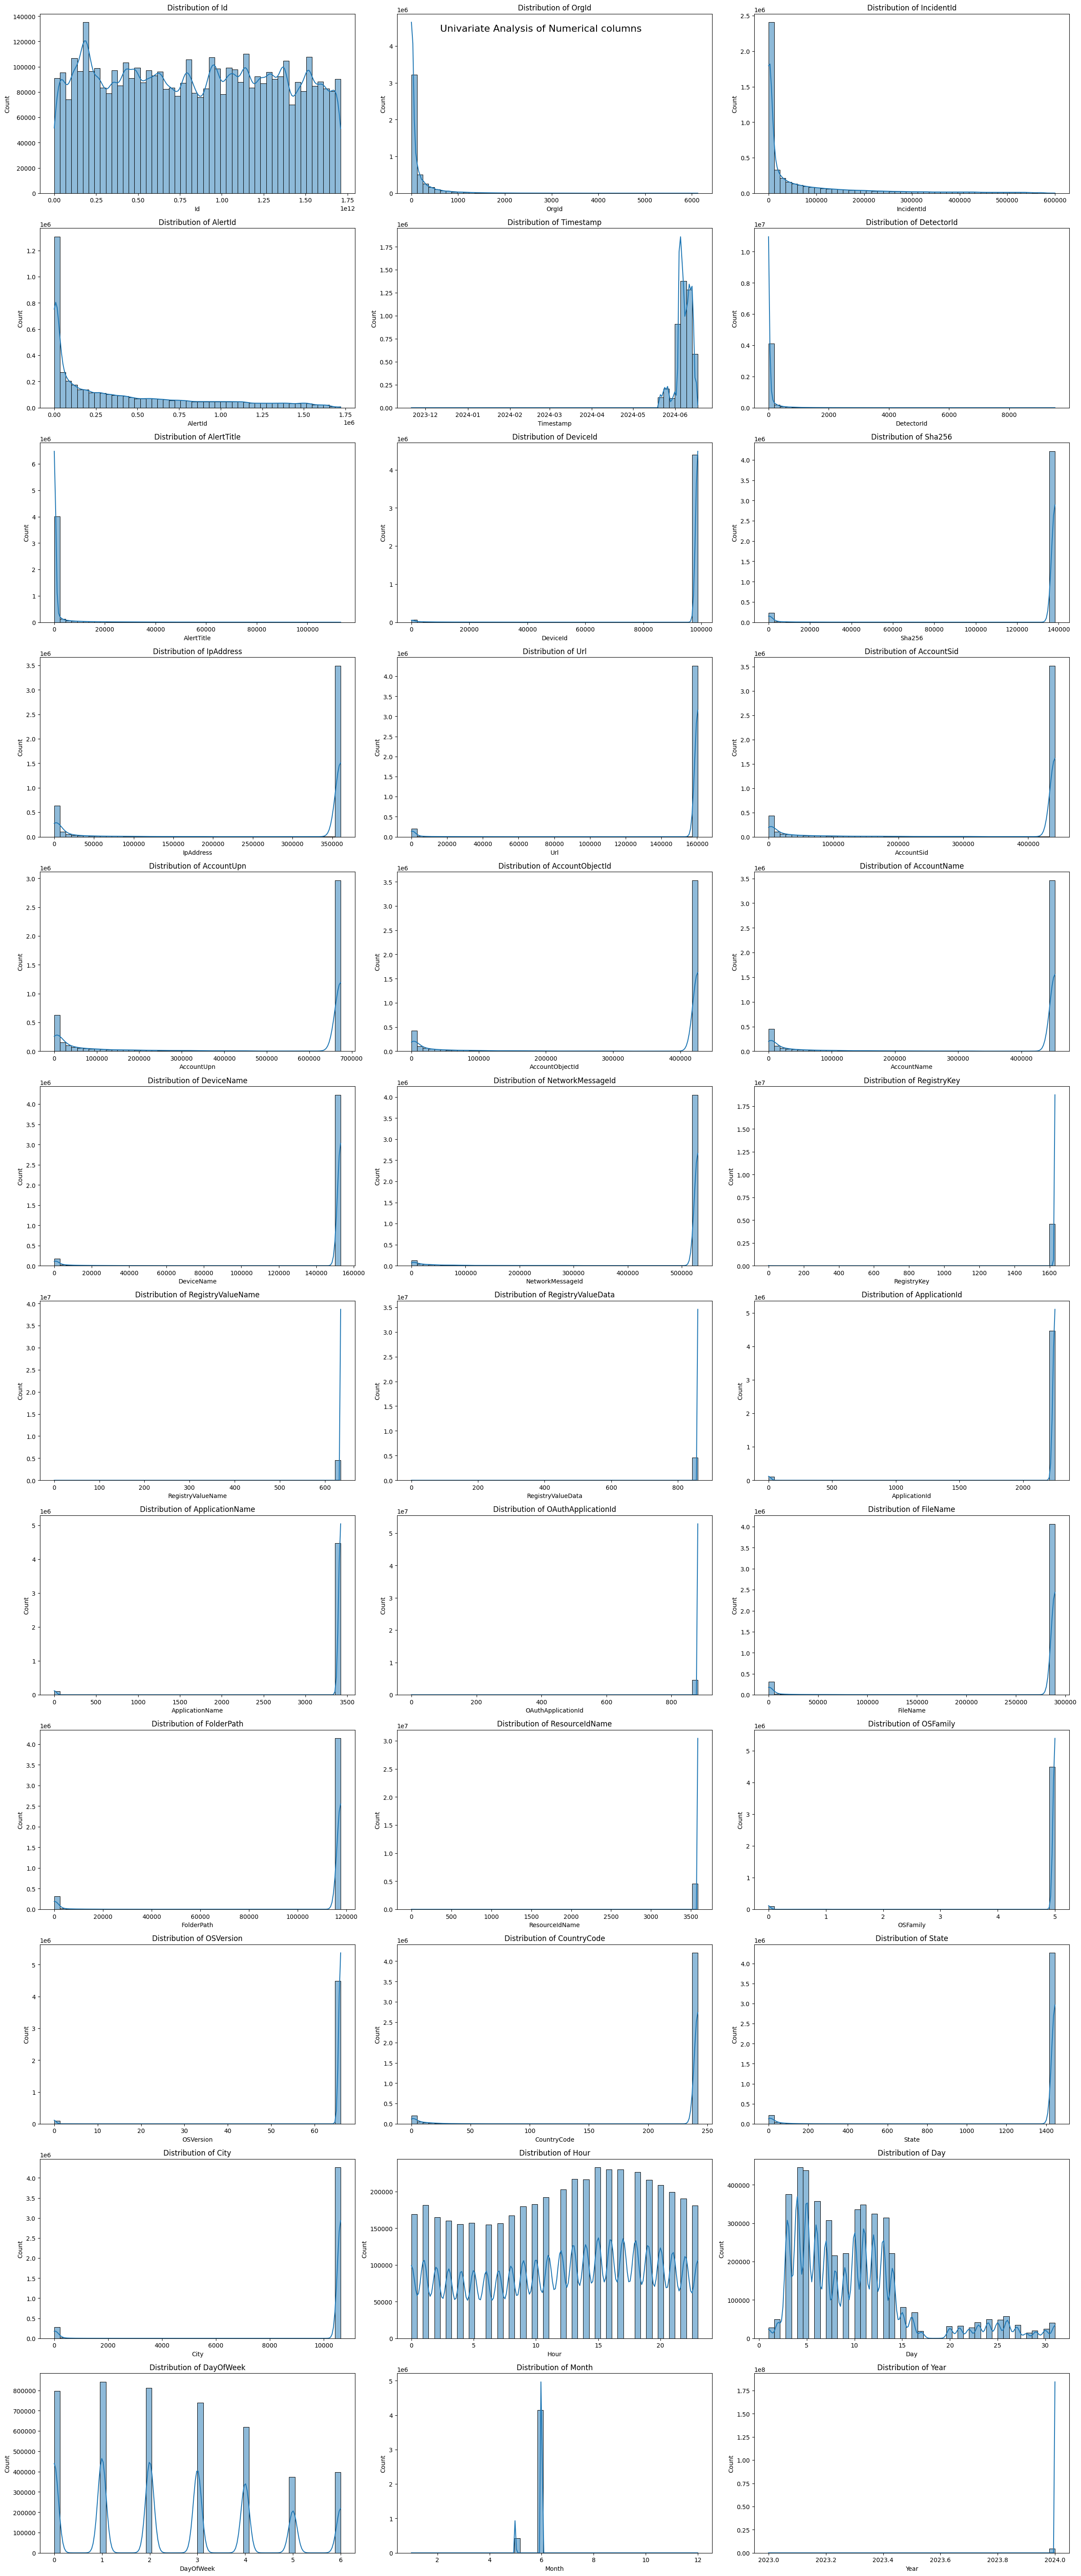

In [17]:
n_cols = 3
n_rows = (len(num_features) + 1) // n_cols
plt.figure(figsize=(25, 5 * n_rows))
plt.suptitle('Univariate Analysis of Numerical columns\n', fontsize=16)

for i, col in enumerate(num_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(clean_df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

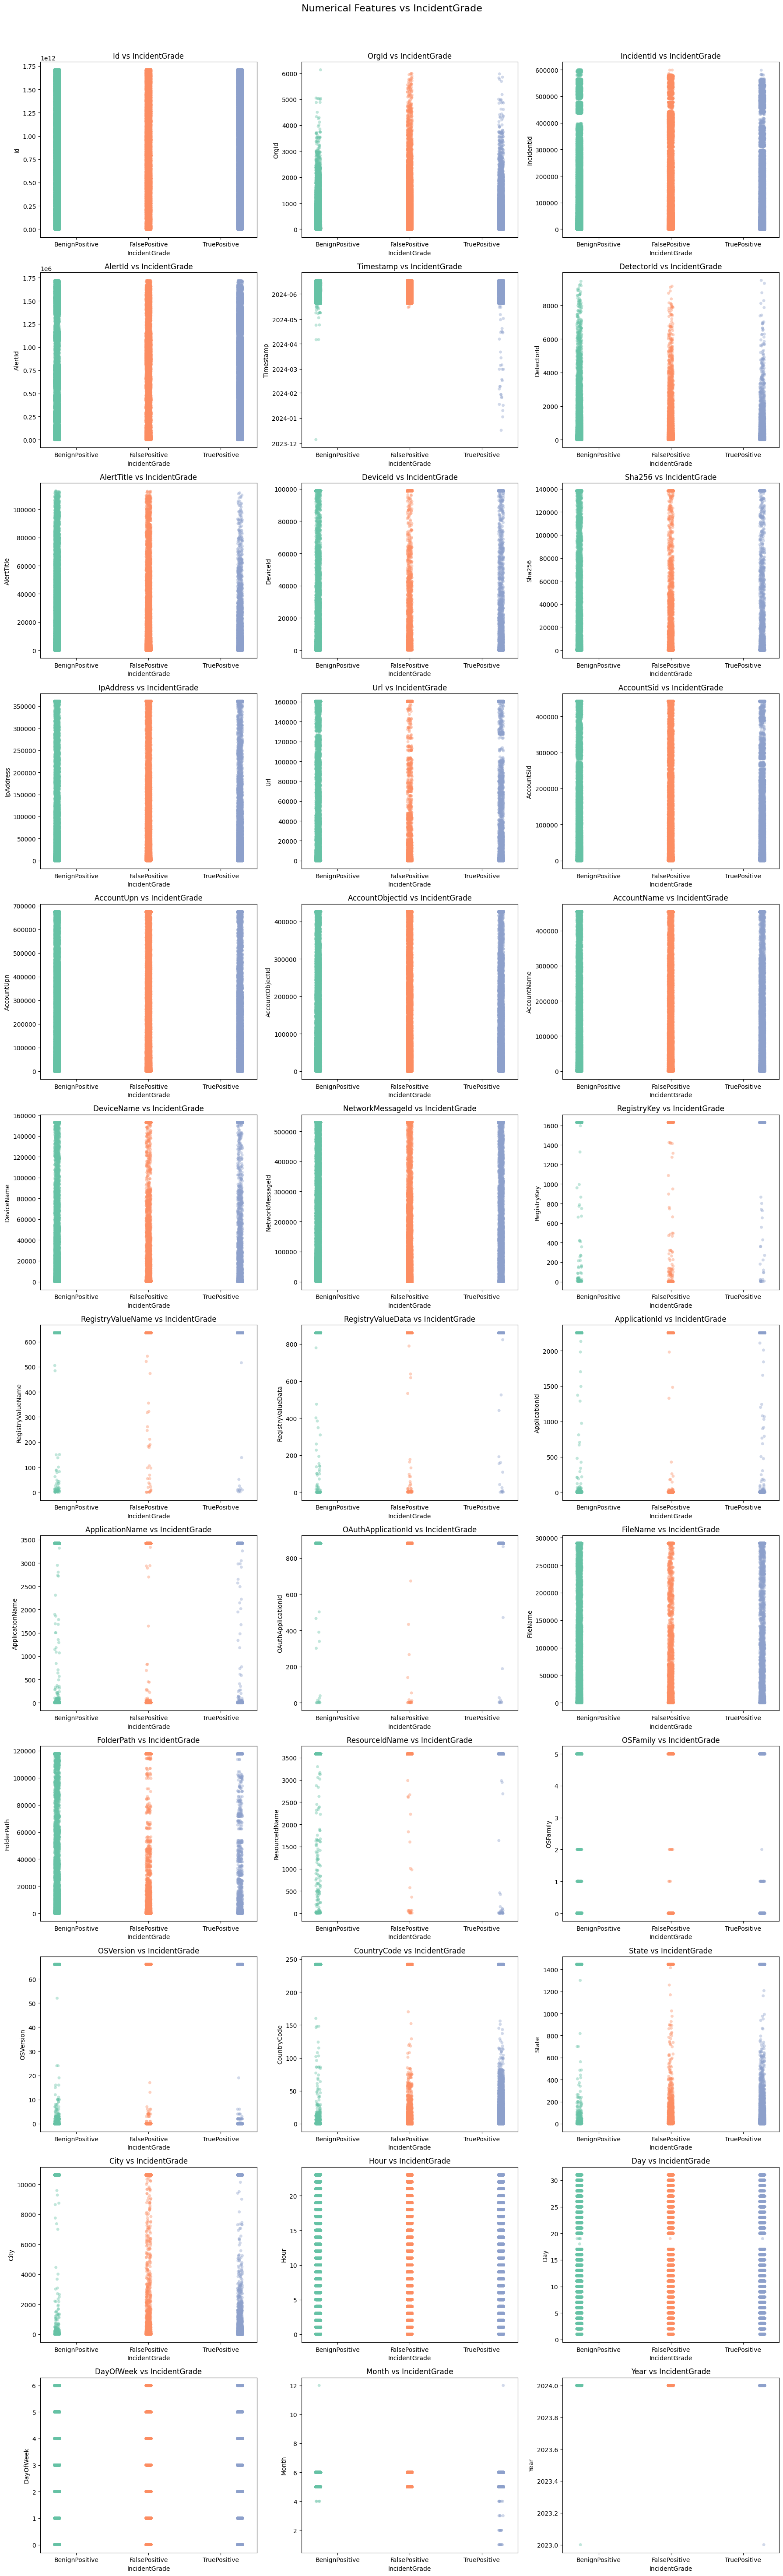

In [20]:
def numerical_vs_target(df, num_features, target='IncidentGrade', sample_frac=0.05):

    sampled_df = df.sample(frac=sample_frac, random_state=42)
    n_cols = 3
    n_rows = (len(num_features) + n_cols - 1) // n_cols
    plt.figure(figsize=(6 * n_cols, 5 * n_rows))
    plt.suptitle(f'Numerical Features vs {target}', fontsize=16)
    
    for i, feature in enumerate(num_features, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.stripplot(data=sampled_df, x=target, y=feature, hue=target, palette='Set2', alpha=0.4, jitter=True, dodge=True, legend=False)
        plt.title(f'{feature} vs {target}')
        plt.xlabel(target)
        plt.ylabel(feature)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

numerical_vs_target(clean_df, num_features)

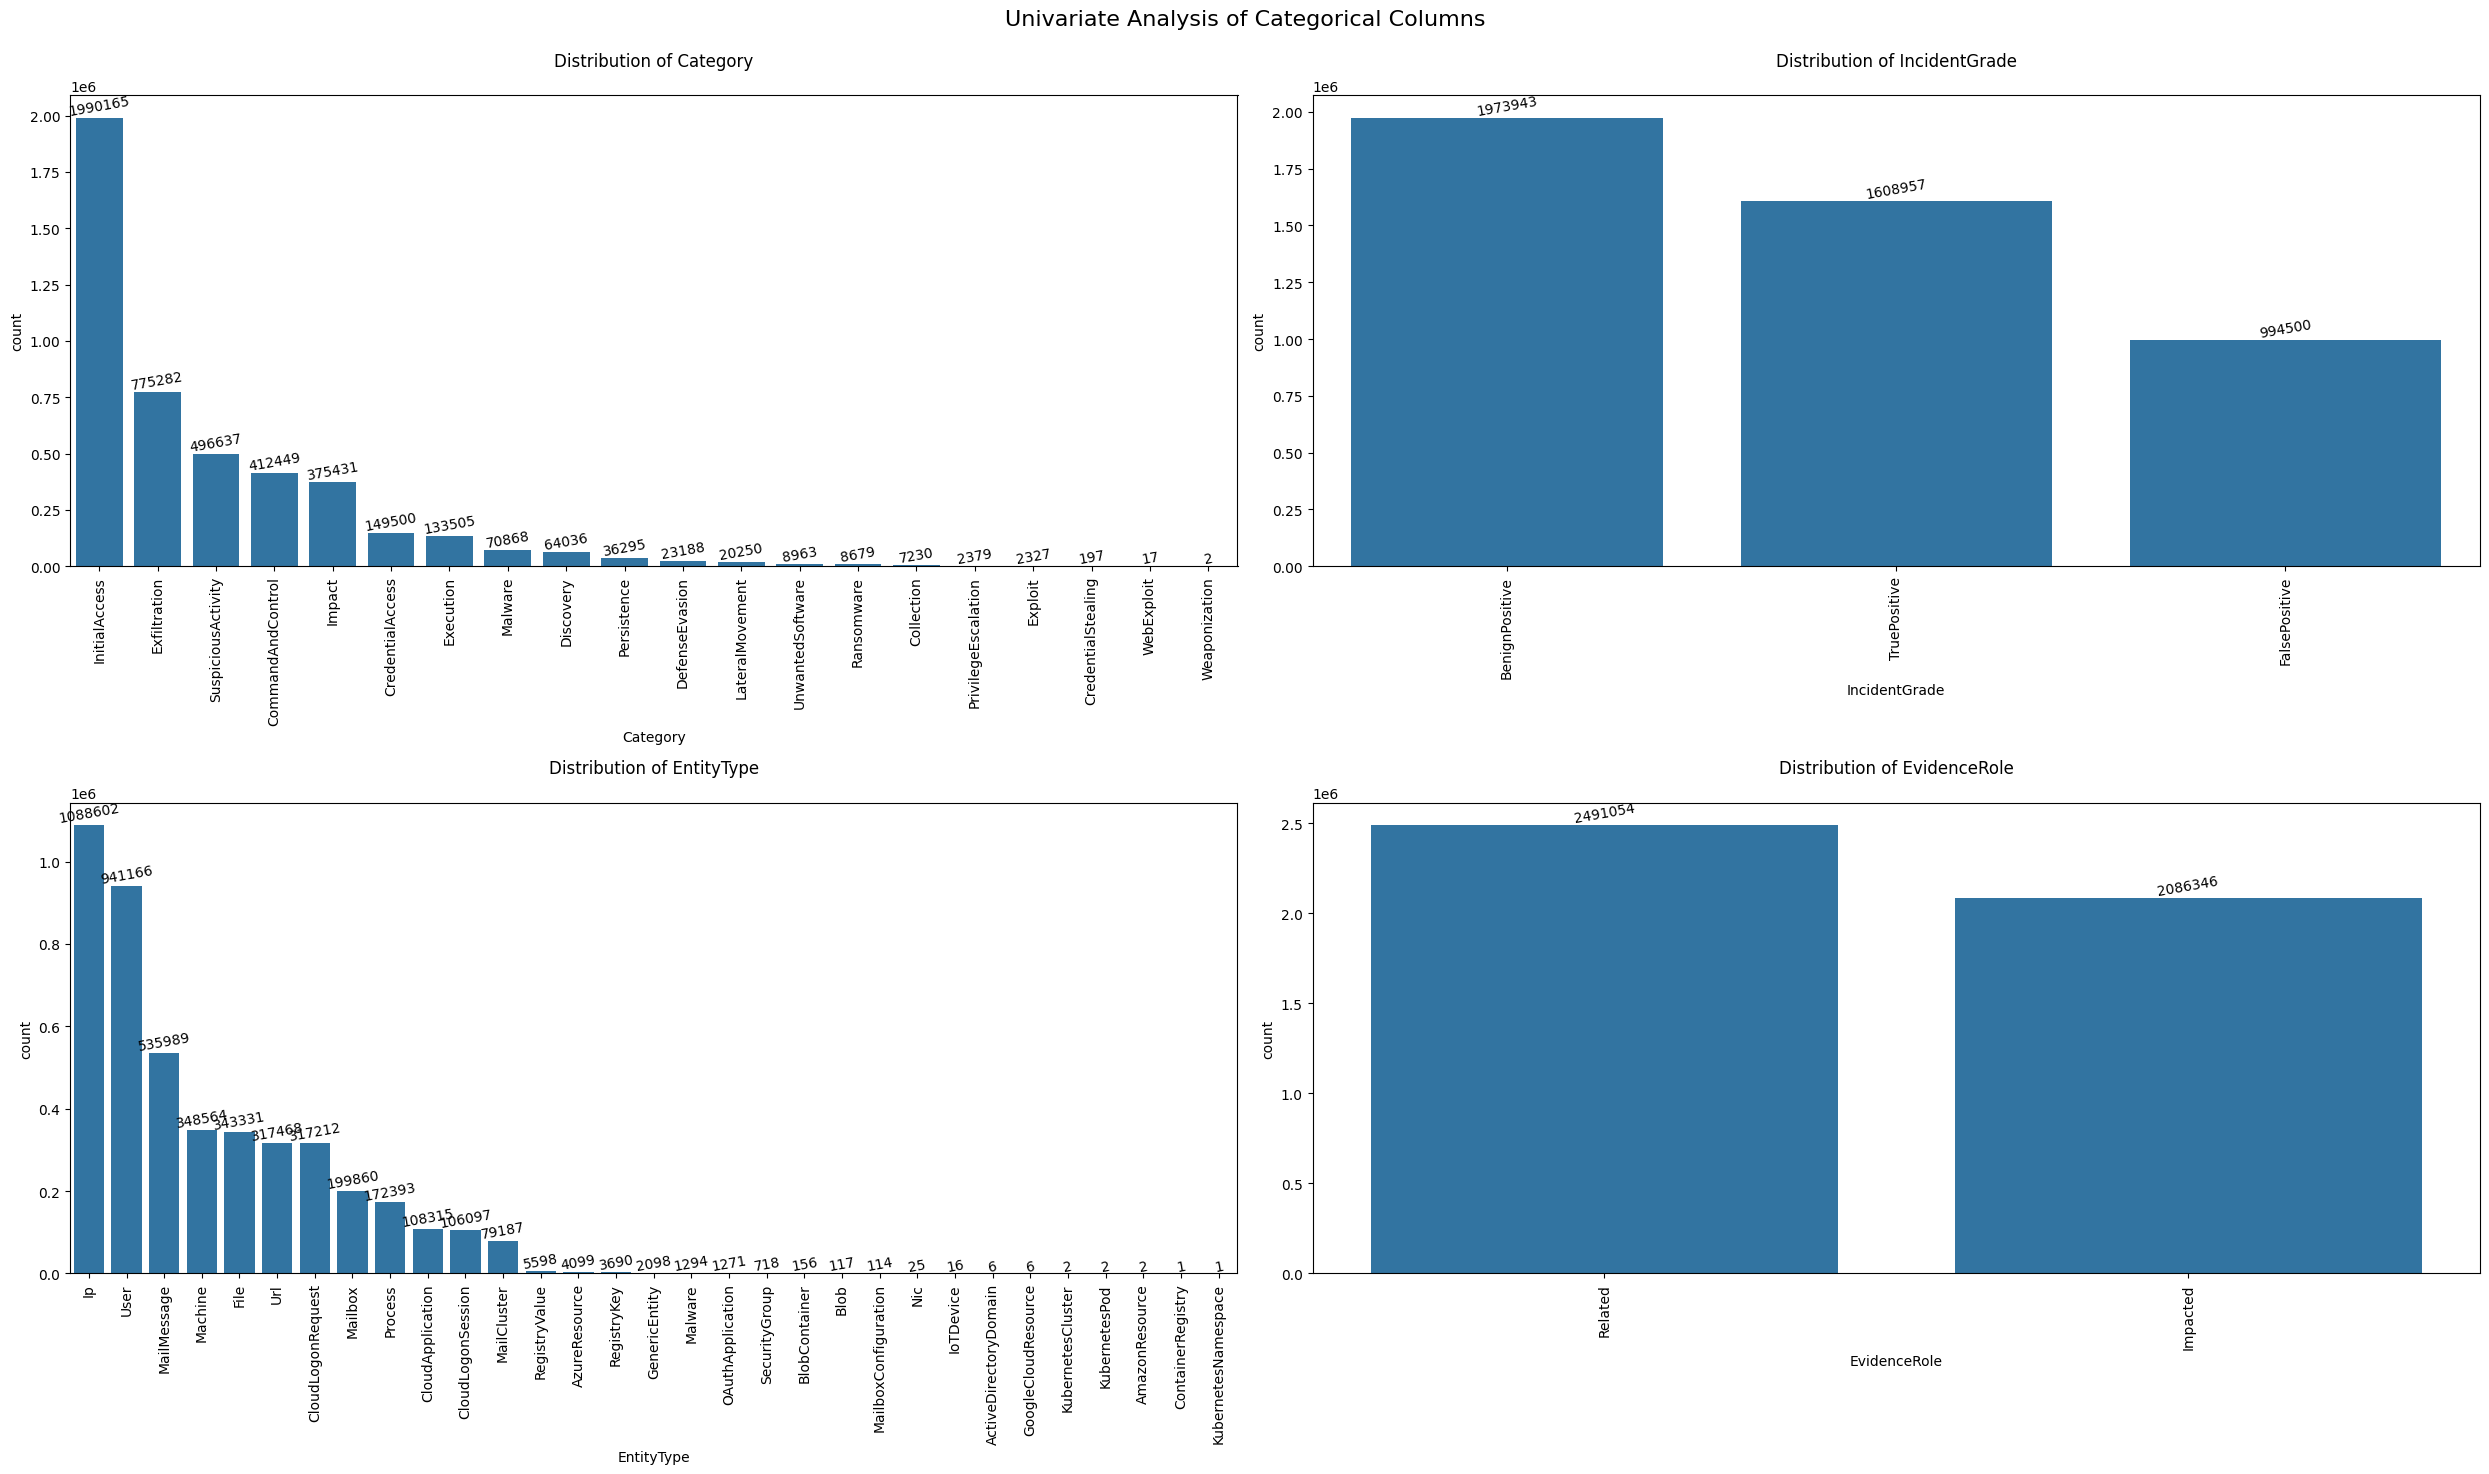

In [21]:
plt.figure(figsize=(25, 15))
plt.suptitle('Univariate Analysis of Categorical Columns\n', fontsize=16)

for i, column in enumerate(cat_features, 1):
    plt.subplot(2, 2, i)
    order = clean_df[column].value_counts().index
    ax = sns.countplot(data=clean_df, x=column, order=order)
    plt.title(f'Distribution of {column}\n')
    plt.xlabel(column)
    plt.xticks(rotation=90)

    for p in ax.patches:
        height = int(p.get_height())
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=10, rotation=10)

plt.tight_layout()
plt.show()

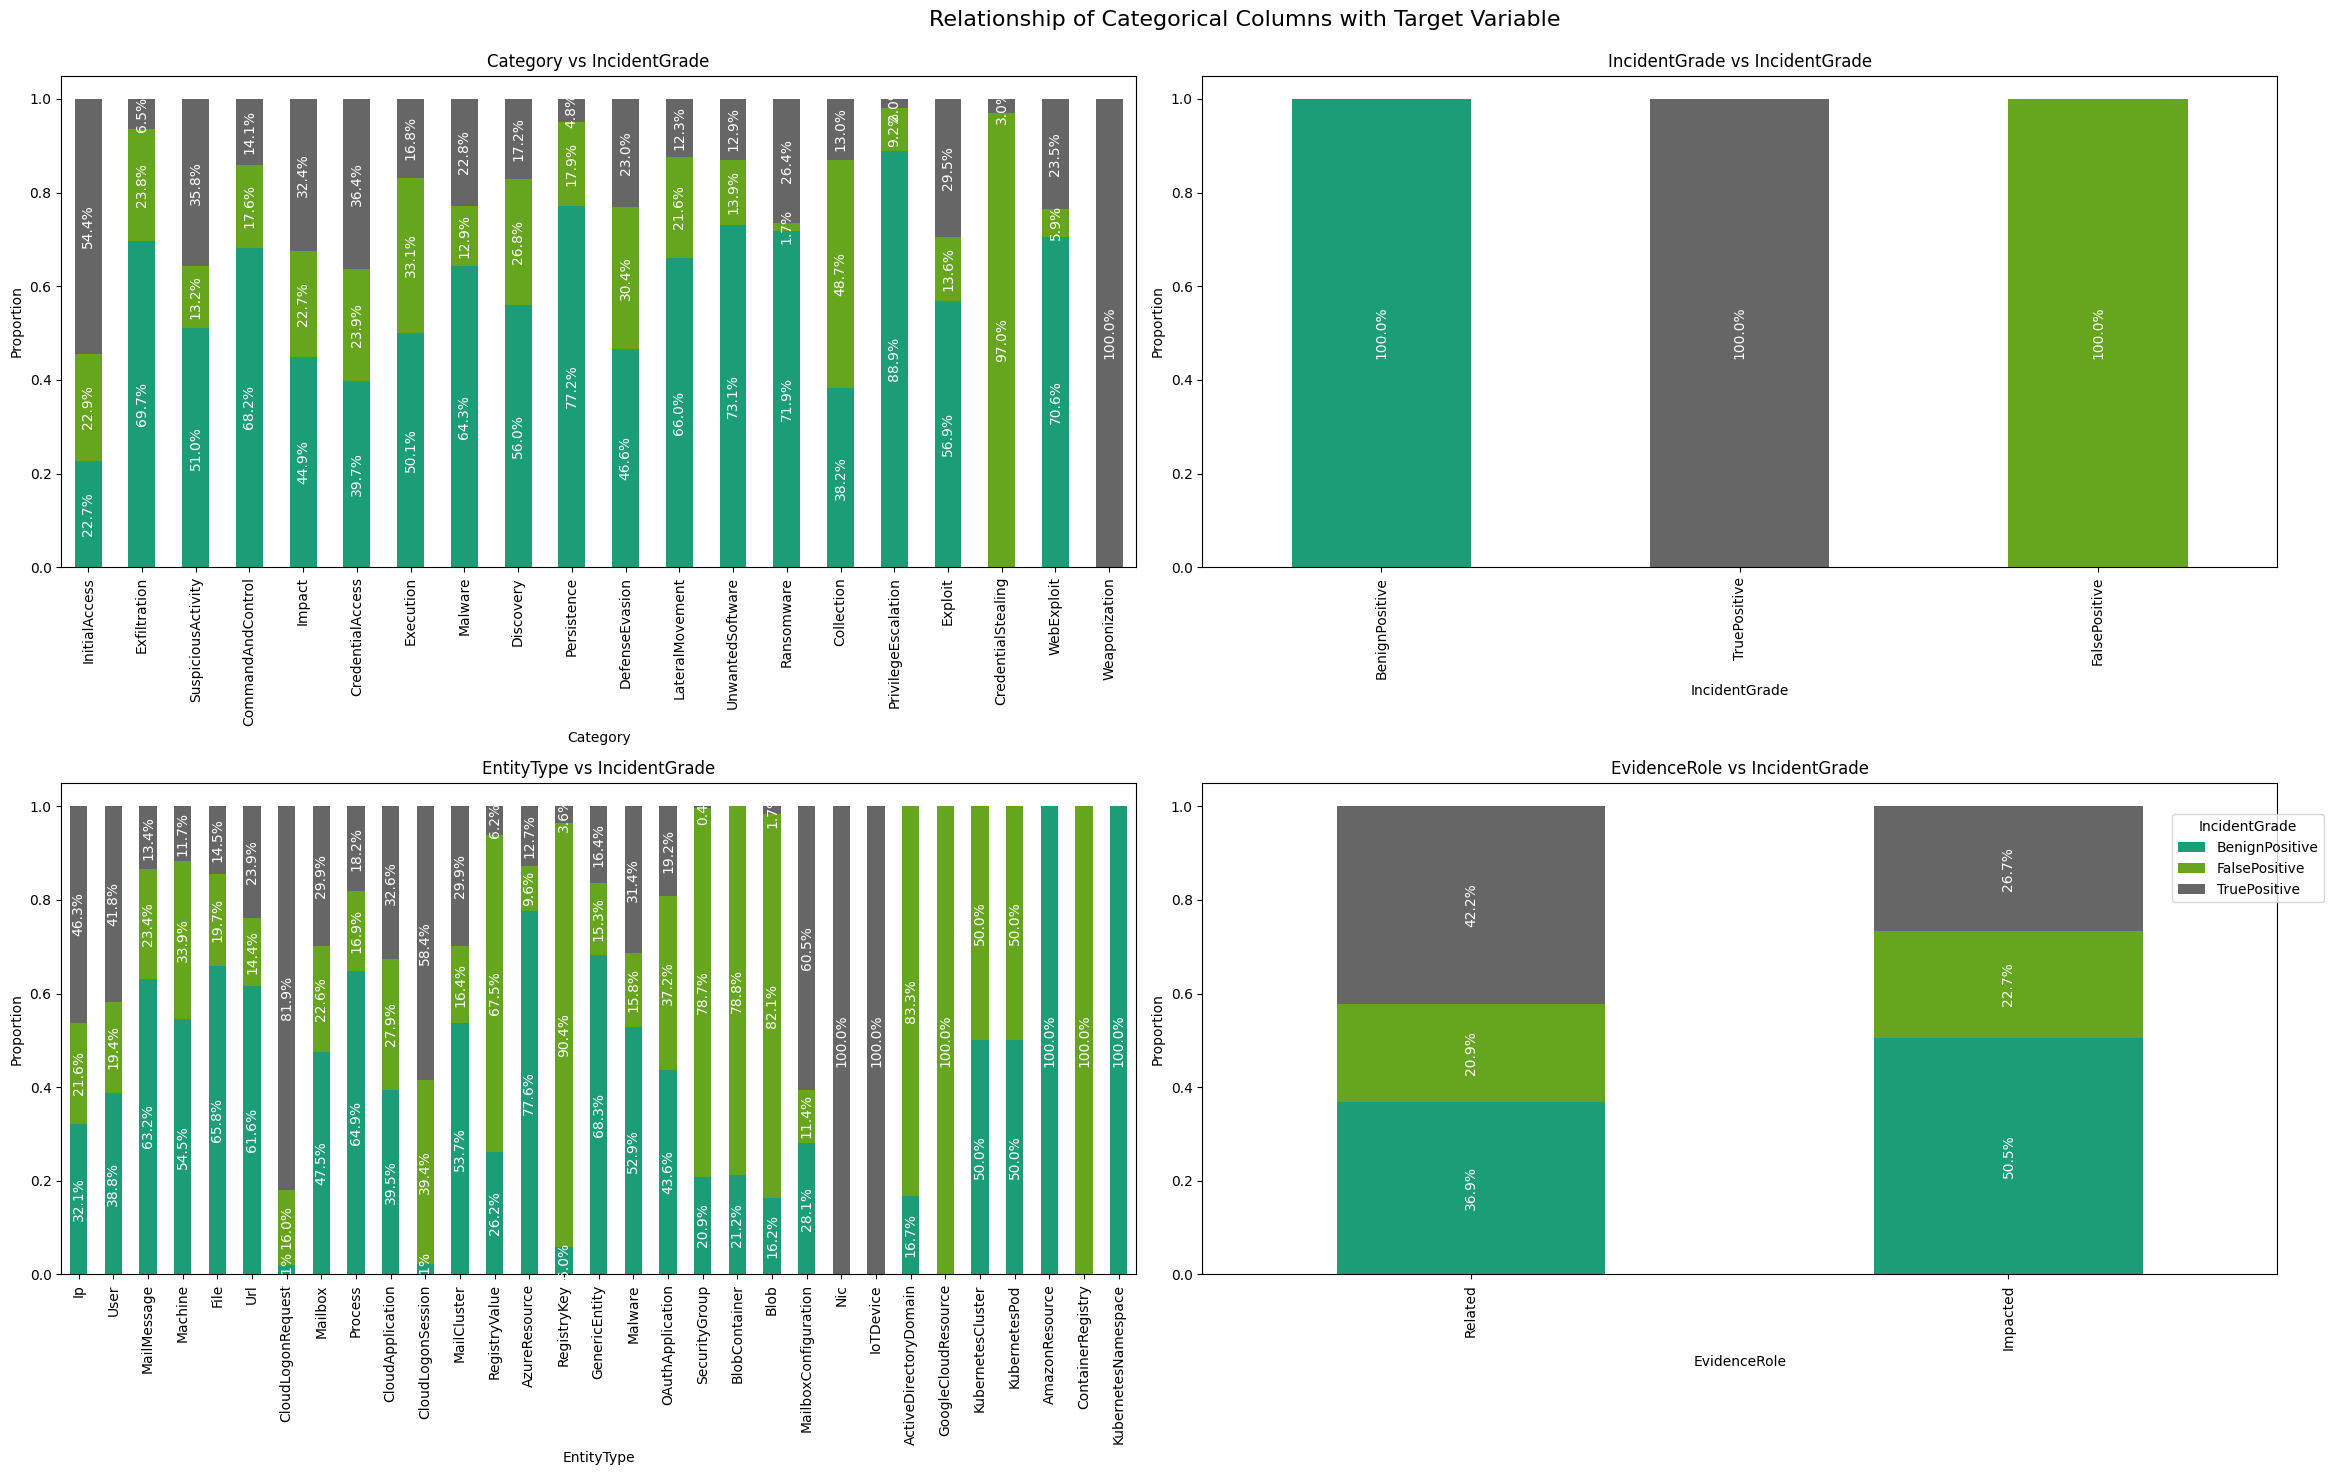

In [22]:
plt.figure(figsize=(25, 15))
plt.suptitle('Relationship of Categorical Columns with Target Variable\n', fontsize=16)

for i, feature in enumerate(cat_features, 1):
    ax = plt.subplot(2, 2, i)

    order = clean_df[feature].value_counts()
    cross_tab = pd.crosstab(clean_df[feature], clean_df['IncidentGrade'], normalize='index')
    cross_tab = cross_tab.loc[order.index]  
    cross_tab.plot(kind='bar', stacked=True, cmap='Dark2', ax=ax, legend=False)

    ax.set_title(f'{feature} vs IncidentGrade')
    ax.set_xlabel(feature)
    ax.set_ylabel('Proportion')
    ax.tick_params(axis='x', rotation=90)

    for i, (idx, row) in enumerate(cross_tab.iterrows()):
        x_pos = i
        y_offset = 0
        for val in row:
            if val > 0:
                ax.text(x_pos, y_offset + val / 2, f"{val * 100:.1f}%", ha='center', va='center', fontsize=10, color='white', rotation=90)
            y_offset += val

plt.legend(title='IncidentGrade', bbox_to_anchor=(1.05, 0.95), loc='best')
plt.tight_layout()
plt.show()

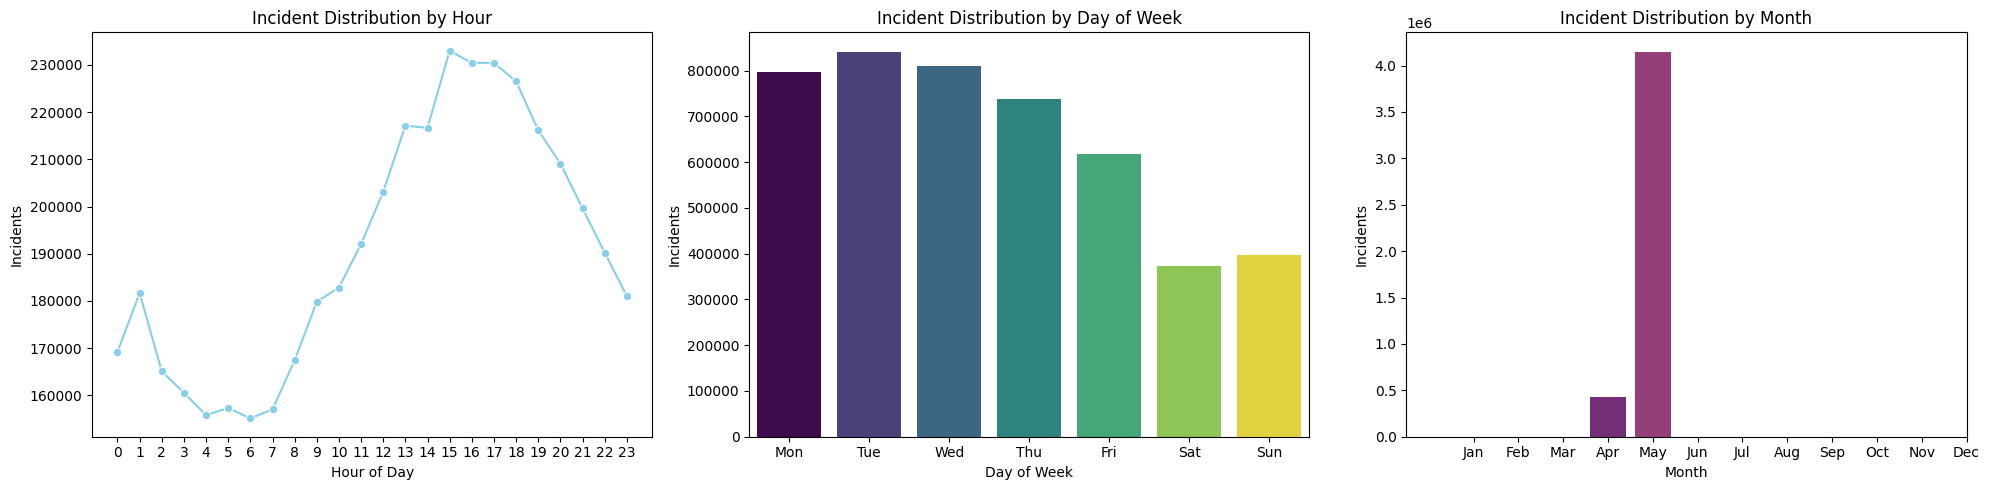

In [23]:
# Function to analyze temporal patterns
def analyze_temporal_patterns(df):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # 1 row, 3 columns

    # --- 1. Hour Analysis ---
    hour_counts = df.groupby('Hour').size()
    sns.lineplot(ax=axes[0], x=hour_counts.index, y=hour_counts.values, marker='o', color='skyblue')
    axes[0].set_title('Incident Distribution by Hour')
    axes[0].set_xticks(range(0, 24))
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Incidents')

    # --- 2. Day of Week Analysis ---
    day_counts = df.groupby('DayOfWeek').size().reset_index(name='count')
    sns.barplot(ax=axes[1], data=day_counts, x='DayOfWeek', y='count', hue='DayOfWeek', palette='viridis', legend=False)
    axes[1].set_title('Incident Distribution by Day of Week')
    axes[1].set_xticks(range(7))
    axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    axes[1].set_xlabel('Day of Week')
    axes[1].set_ylabel('Incidents')

    # --- 3. Month Analysis ---
    month_counts = df.groupby('Month').size().reset_index(name='count')
    sns.barplot(ax=axes[2], data=month_counts, x='Month', y='count', hue='Month', palette='magma', legend=False)
    axes[2].set_title('Incident Distribution by Month')
    axes[2].set_xticks(range(1, 13))
    axes[2].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axes[2].set_xlabel('Month')
    axes[2].set_ylabel('Incidents')

    plt.tight_layout()
    plt.show()

analyze_temporal_patterns(clean_df)

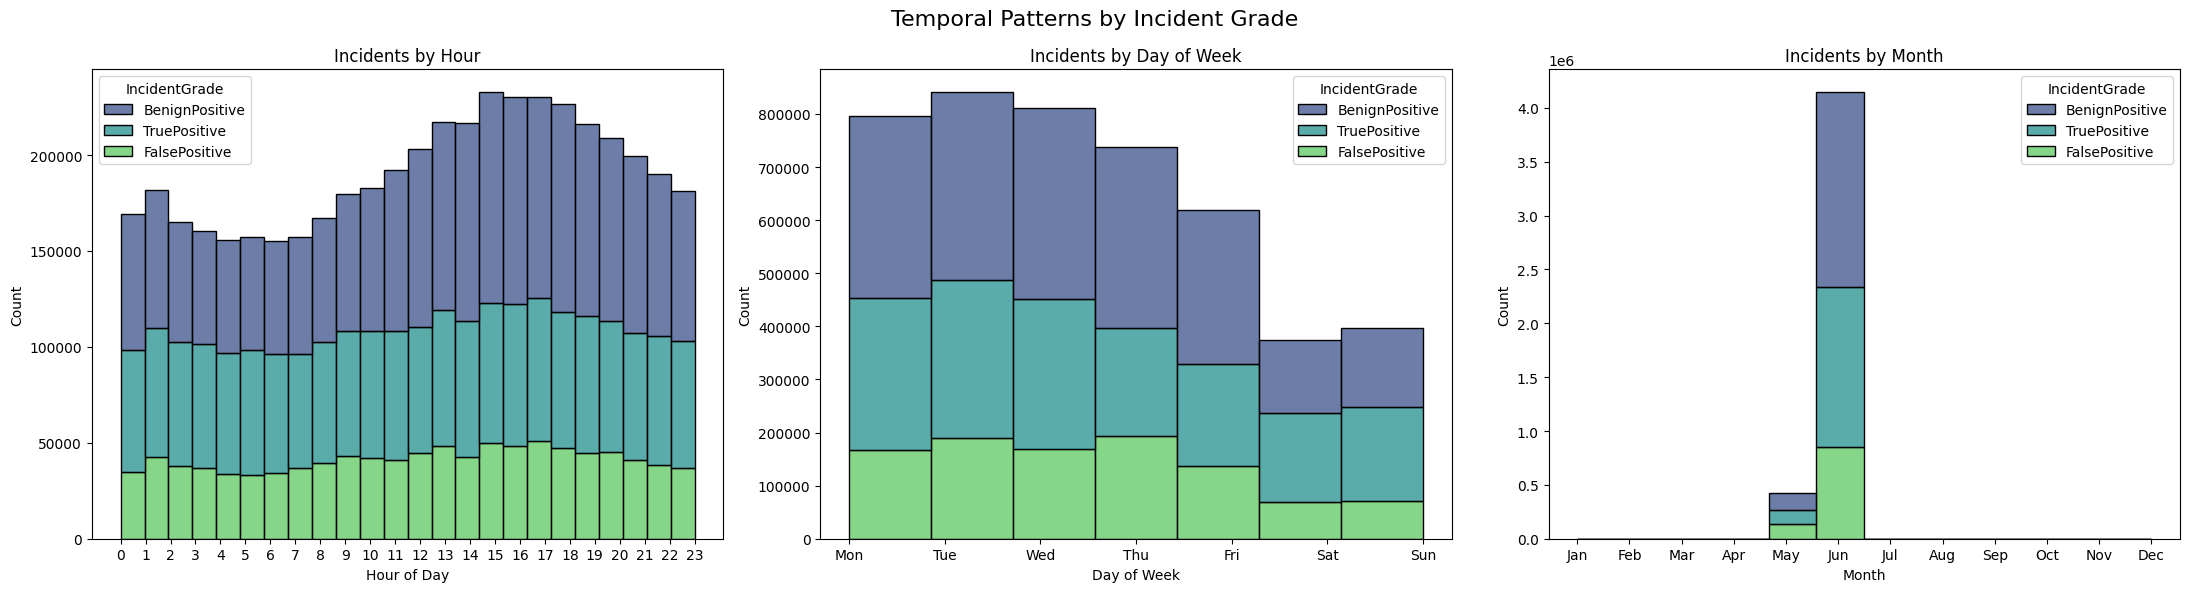

In [25]:
def analyze_temporal_patterns_by_target(df, target_col='IncidentGrade'):
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    plt.suptitle('Temporal Patterns by Incident Grade', fontsize=16)

    # 1. Hour vs Target
    sns.histplot(data=df, x='Hour', hue=target_col, multiple='stack', palette='viridis', edgecolor='black', ax=axes[0], bins=24)
    axes[0].set_title('Incidents by Hour')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Count')
    axes[0].set_xticks(range(0, 24))

    # 2. DayOfWeek vs Target
    sns.histplot(data=df, x='DayOfWeek', hue=target_col, multiple='stack', palette='viridis', edgecolor='black', ax=axes[1], bins=7)
    axes[1].set_title('Incidents by Day of Week')
    axes[1].set_xlabel('Day of Week')
    axes[1].set_ylabel('Count')
    axes[1].set_xticks(range(7))
    axes[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # 3. Month vs Target
    sns.histplot(data=df, x='Month', hue=target_col, multiple='stack', palette='viridis', edgecolor='black', ax=axes[2], bins=12)
    axes[2].set_title('Incidents by Month')
    axes[2].set_xlabel('Month')
    axes[2].set_ylabel('Count')
    axes[2].set_xticks(range(1, 13))
    axes[2].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    plt.tight_layout()
    plt.show()

analyze_temporal_patterns_by_target(clean_df)

In [28]:
corr = clean_df[num_features].corr()
corr_pairs = corr.unstack() # understanding the correlated pairs

sorted_corr_pairs = corr_pairs.abs().sort_values(ascending=False)
high_corr_pairs = sorted_corr_pairs[(sorted_corr_pairs > 0.8) & (sorted_corr_pairs < 1.0)]

filtered_pairs = {}
for (col1, col2), corr in high_corr_pairs.items():
    if (col2, col1) not in filtered_pairs:
        filtered_pairs[(col1, col2)] = corr

for (col1, col2), corr in filtered_pairs.items():
    print(f"{col1:20} {col2:20} {corr:.6f}")

OSFamily             OSVersion            0.999284
State                City                 0.996450
ApplicationName      ApplicationId        0.986131
AccountObjectId      AccountSid           0.984697
AccountName          AccountSid           0.963495
AccountName          AccountObjectId      0.956707
State                CountryCode          0.912697
CountryCode          City                 0.909738
FolderPath           FileName             0.884055
Sha256               FileName             0.863156
RegistryValueName    RegistryValueData    0.829725


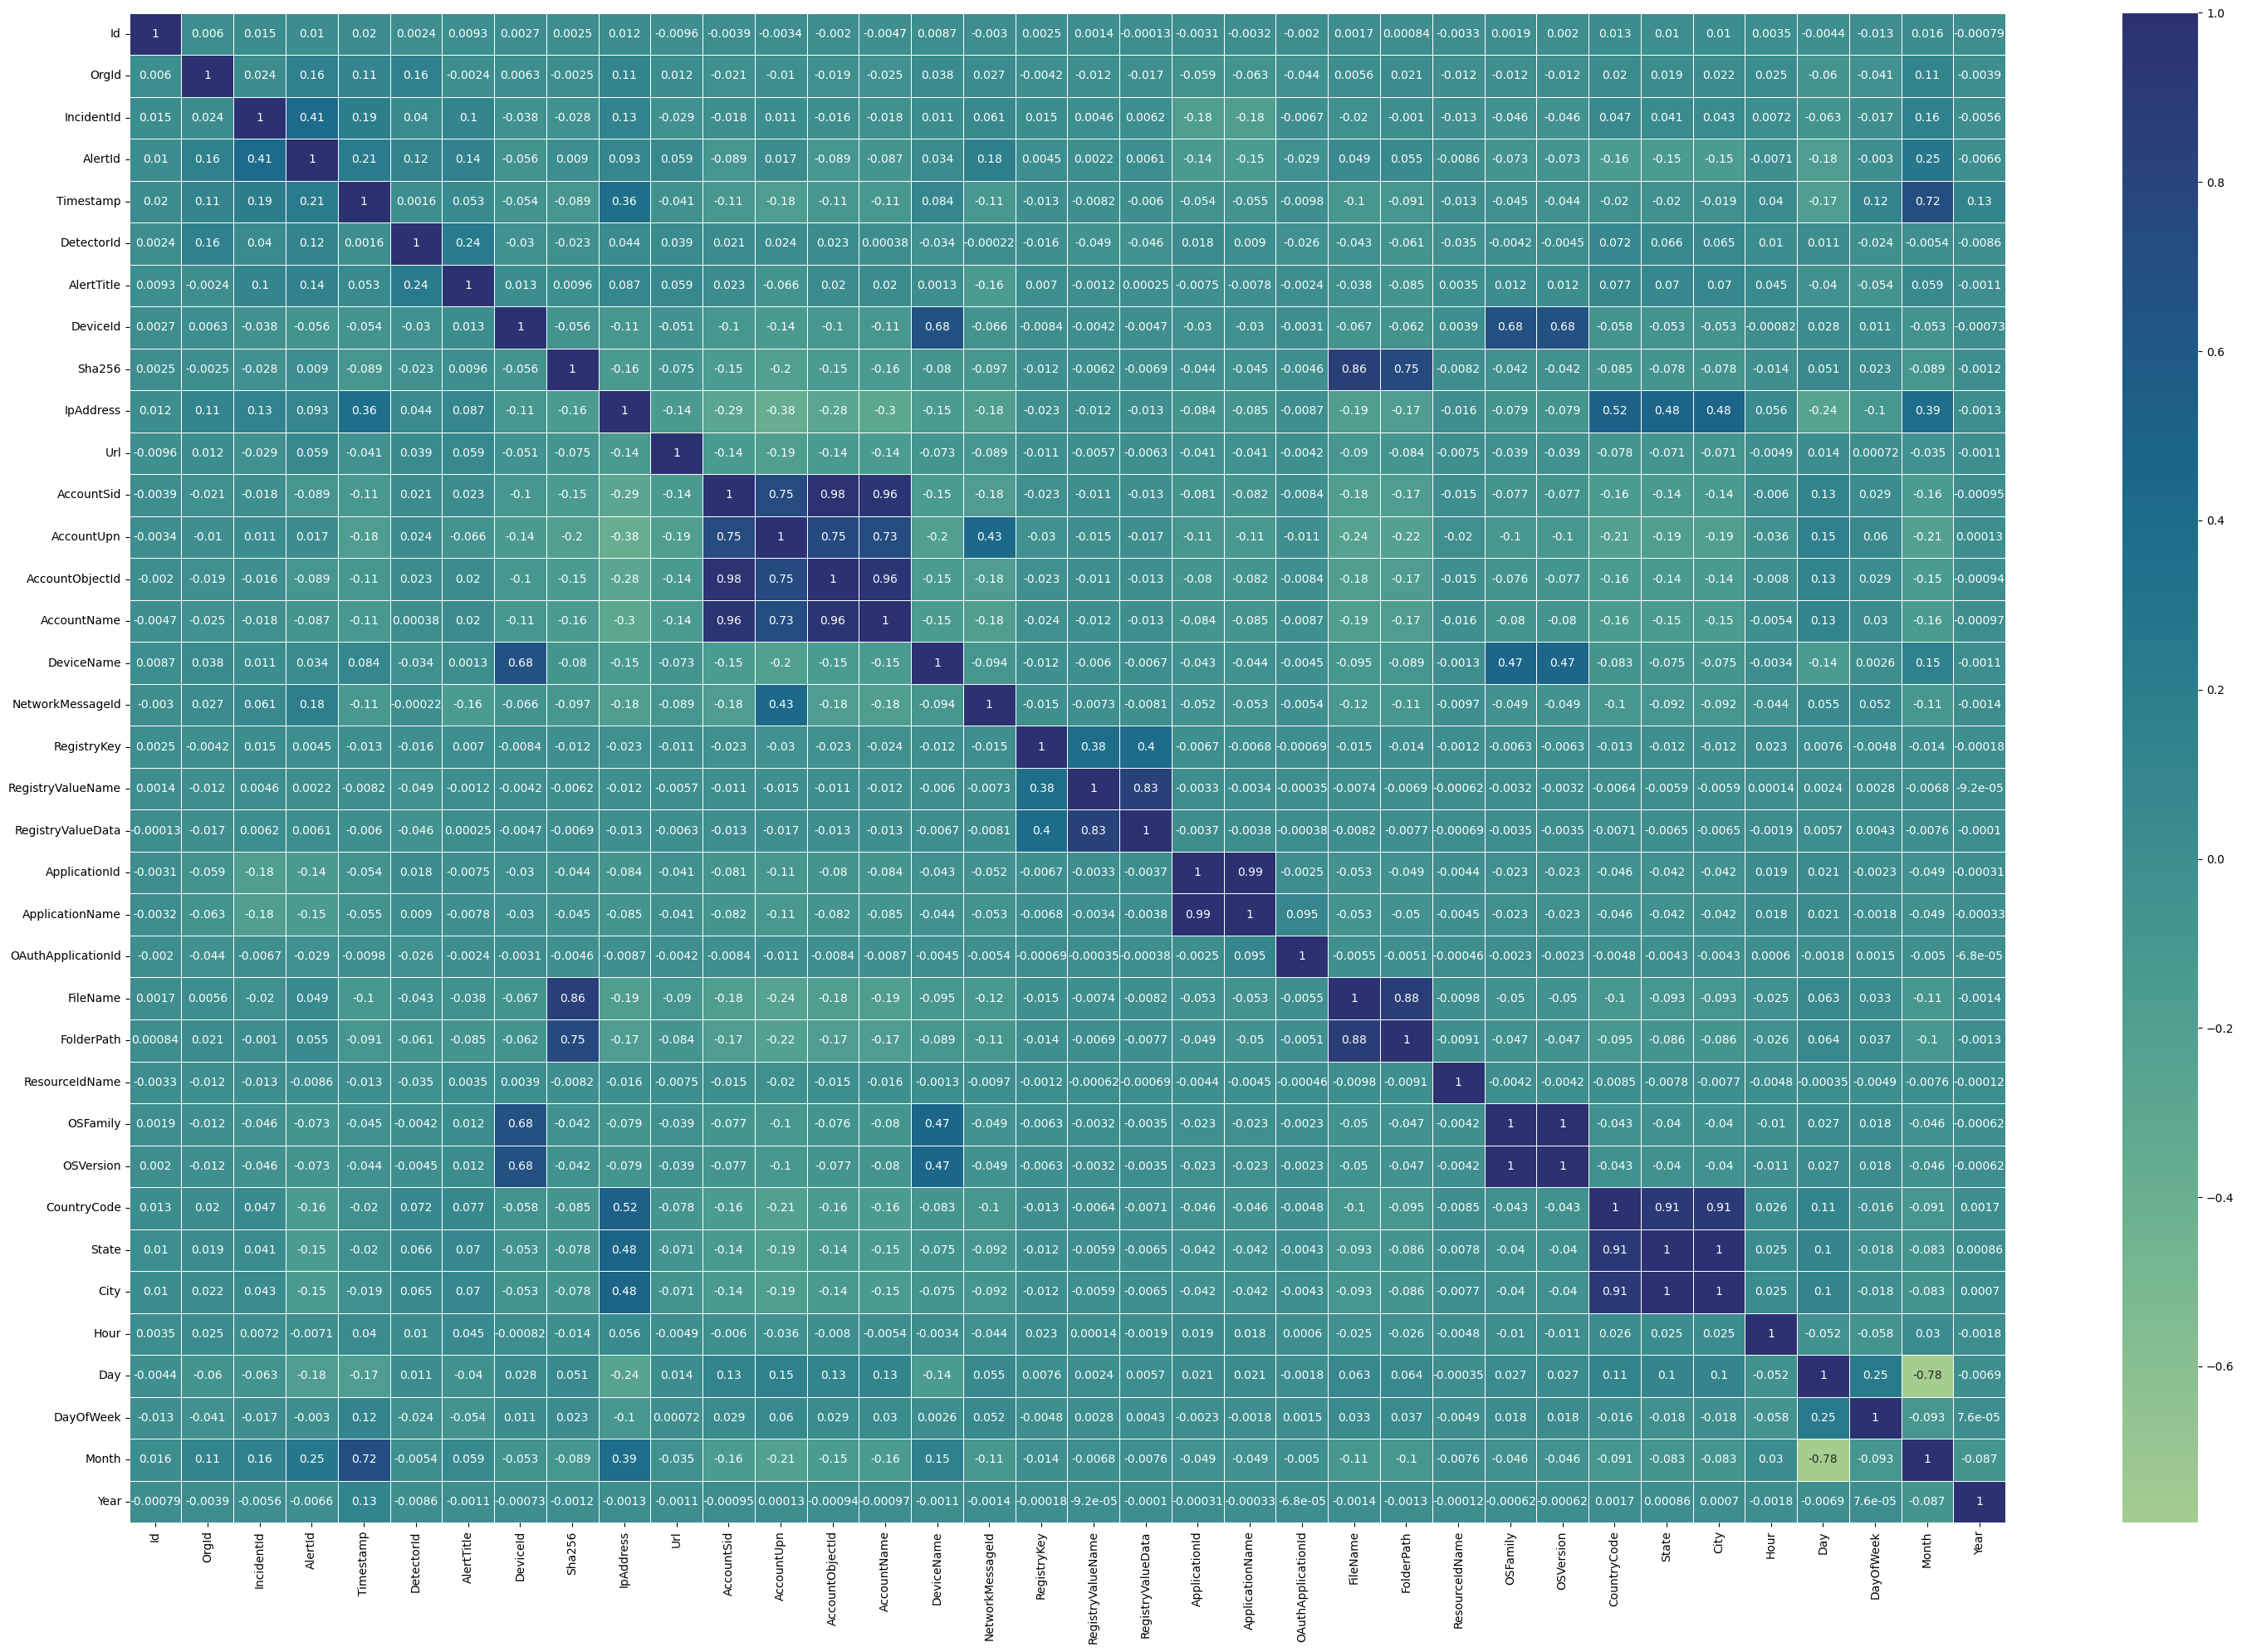

In [30]:
plt.figure(figsize = (30, 20))
sns.heatmap(clean_df[num_features].corr(), cmap = 'crest', annot = True, linewidth = 0.5)
plt.tight_layout()  
plt.show()